### Preparing Dataset for Mask-RCNN

In [1]:
import os
import json
from tqdm import tqdm
from glob import glob

In [2]:
MIXED_DATASET = 'dataset'
dataset_name = 'coco_dataset'

# Create COCO dataset

In [3]:
target_dir = os.path.join(dataset_name)

In [4]:
os.mkdir(target_dir)

In [5]:
ann_path = os.path.join(target_dir, 'annotations')
os.mkdir(ann_path)

### Check if annotations correspond to images

In [6]:
img_files = glob(os.path.join(MIXED_DATASET, 'img', '*'))
ann_files = glob(os.path.join(MIXED_DATASET, 'ann', '*'))

In [7]:
def write_list(what, where):
    file = open(where, 'w')
    file.writelines(s + '\n' for s in what)
    file.close()
    
def get_list(where):
    file = open(where, 'r')
    what = []
    for line in file.readlines():
        if line:
            what.append(line.strip('\n'))
    file.close()
    return what

In [8]:
img_names = [f.split('/')[-1].split('.')[0] for f in img_files]
ann_names = [f.split('/')[-1].split('.')[0] for f in ann_files]

print(set(img_names) - set(ann_names), set(ann_names) -  set(img_names))
assert set(img_names) == set(ann_names)

write_list(img_names, os.path.join(MIXED_DATASET, 'names.txt'))

set() set()


## Create a split

In [9]:
from sklearn.model_selection import train_test_split
import numpy as np

img_names = np.array(img_names)  #convert array to numpy type array
train, testval = train_test_split(img_names, test_size=0.2)  

In [10]:
write_list(train, os.path.join(MIXED_DATASET, 'train.txt'))
write_list(testval, os.path.join(MIXED_DATASET, 'test.txt'))
write_list(testval, os.path.join(MIXED_DATASET, 'val.txt'))

In [11]:
train = get_list(os.path.join(MIXED_DATASET, 'train.txt'))
test = get_list(os.path.join(MIXED_DATASET, 'test.txt'))
val = get_list(os.path.join(MIXED_DATASET, 'val.txt'))

In [31]:
from PIL import Image

class CocoImage:
    def __init__(self, file_name, id, path):
        self.coco_url = None
        self.date_captured = None 
        self.file_name = file_name
        self.id = id
        
        img = Image.open(path)
        self.height = img.size[1]
        self.width = img.size[0]
        self.licence = 1
    
    def to_dict(self):
        return {
            'coco_url': self.coco_url,
            'date_captured': self.date_captured,
            'file_name': self.file_name,
            'flickr_url': self.coco_url,
            'height': self.height,
            'id': self.id,
            'license': self.licence,
            'width': self.width
        }

In [114]:
class CocoAnnotation:
    def __init__(self, image_id, objects, image_meta):
        self.area = None
        self.image_id = image_id
        self.iscrowd = 0
        
        img = Image.open(path)
        self.segmentation = img.size[1]
    
    def to_dict(self):
        return {
            'coco_url': self.coco_url,
            'date_captured': self.date_captured,
            'file_name': self.file_name,
            'flickr_url': self.coco_url,
            'height': self.height,
            'id': self.id,
            'license': self.licence,
            'width': self.width
        }
    
    
def convert_segmentation(segm):
    startX = segm[0][0]
    startY = segm[0][1]
    endX = segm[0][2]
    endY = segm[0][3]
    
    return [[startX, startY, endX, startY, endX, endY, startX, endY]]

In [115]:
source = '/home/klyshko/Desktop/HLML/machinelearning/projects/colony_classification'

In [116]:
import json

class_categories = [
        {
            "supercategory": "g",
            "id": 0,
            "name": "g"
        },
        {
            "supercategory": "p",
            "id": 1,
            "name": "p"
        }
    ]

for ds_type, files in [('val', val), ('test', test), ('train', train)]:
    images_path = os.path.join(target_dir, ds_type)
    
    os.makedirs(images_path, exist_ok=True)
    ann = {
        'images': [],
        'annotations': [],
        'licenses': [],
        'categories': class_categories,
        'info': {}
    }
    label_id = 1
    
    for image_id, name in enumerate(img_names):
        img_path = os.path.join(MIXED_DATASET, 'img', name + '.png')
        full_img_path = os.path.join(source, img_path)
        img_data = CocoImage(name + '.png', image_id + 1, full_img_path)
        
        if name in files:
            ann['images'].append(img_data.to_dict())
            img = Image.open(full_img_path)
            img_area = img.size[0] * img.size[1]
            is_crowd = 0
            
            object_anns = json.load(open(os.path.join(MIXED_DATASET, 'ann', name + '.json'), 'rb'))
            
            for obj_ann in object_anns['annotations']:
                
                
                
                ann_instance = {
                        "area": img_area,
                        "category_id": obj_ann['category_id'],
                        "id": label_id, #obj_ann['id'],
                        "image_id": image_id + 1,
                        "iscrowd": is_crowd,
                        "segmentation" : convert_segmentation(obj_ann['segmentation']),
                        "bbox" : obj_ann['bbox']
                    }
                ann['annotations'].append(ann_instance)
                label_id += 1

            #SAVE IMAGE
            img.save(os.path.join(images_path, name + '.png'))
    print(len(ann['images']))
    # SAVE ANNOTATION
    with open(os.path.join(ann_path, 'instances_{}.json'.format(ds_type)), 'w') as f:
        json.dump(ann, f)
            

4
4
16


# Check dataset

In [117]:
%matplotlib inline
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [118]:
coco=COCO(os.path.join(ann_path, 'instances_val.json'))


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [119]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
g p

COCO supercategories: 
p g


In [120]:
catIds = coco.getCatIds(catNms=['g', 'p']);
imgIds = coco.getImgIds(catIds=catIds );
#imgIds = coco.getImgIds(imgIds = [100])
img = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]

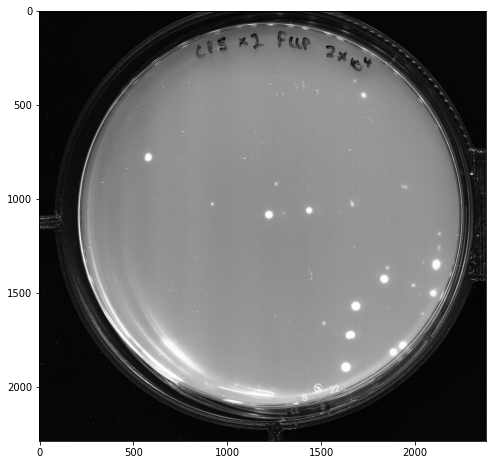

In [121]:
I = Image.open("{}/val/{}".format(target_dir, img['file_name'])).convert('RGB')
#plt.axis('off')
plt.imshow(I)
plt.show()

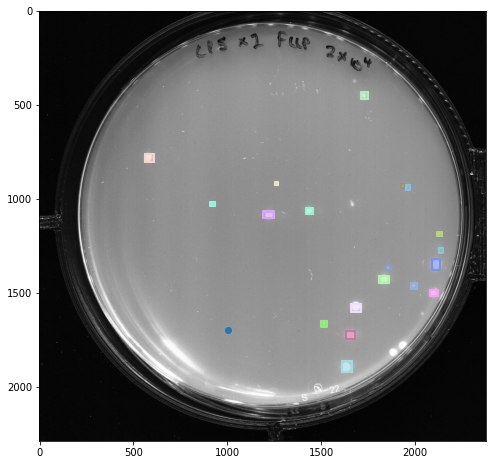

In [122]:
plt.imshow(I); #plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
plt.scatter(1003, 1696, marker='o')
coco.showAnns(anns, True)


In [103]:
anns

[{'area': 5436288,
  'category_id': 0,
  'id': 183,
  'image_id': 20,
  'iscrowd': 0,
  'segmentation': [[1379.3103448275863,
    413.7931034482759,
    1387.9310344827586,
    413.7931034482759,
    1387.9310344827586,
    446.55172413793105,
    1379.3103448275863,
    446.55172413793105]],
  'bbox': [1379.0, 413.0, 8.0, 33.0]},
 {'area': 5436288,
  'category_id': 0,
  'id': 184,
  'image_id': 20,
  'iscrowd': 0,
  'segmentation': [[1496.5517241379312,
    608.6206896551724,
    1513.793103448276,
    608.6206896551724,
    1513.793103448276,
    627.5862068965517,
    1496.5517241379312,
    627.5862068965517]],
  'bbox': [1496.0, 608.0, 17.0, 19.0]},
 {'area': 5436288,
  'category_id': 0,
  'id': 185,
  'image_id': 20,
  'iscrowd': 0,
  'segmentation': [[1541.3793103448277,
    531.0344827586207,
    1556.8965517241381,
    531.0344827586207,
    1556.8965517241381,
    558.6206896551724,
    1541.3793103448277,
    558.6206896551724]],
  'bbox': [1541.0, 531.0, 15.0, 27.0]},
 {'ar